In [77]:
import torch
import numpy as np

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", font_scale=1)

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [79]:
def draw_linear(
    x: torch.Tensor, 
    y_actual: torch.Tensor,
    w_actual: torch.Tensor,
    y_predict: torch.Tensor = None,
    w_predicted: torch.Tensor = None
):
  linear_grid = torch.linspace(x.min(), x.max(), 100)
  
  if y_predict is not None:
    plt.scatter(x, y_predict, label="predict")
  
  if w_predicted is not None:
    plt.plot(linear_grid, linear_grid * w_predicted[0] + w_predicted[1], label="predicted linear")
    
  plt.scatter(x, y_actual, label="true")
  plt.plot(linear_grid, linear_grid * w_actual[0] + w_actual[1], label="actual linear")

  plt.title("Dependecies")
  plt.xlabel("X")
  plt.ylabel("y")
  plt.legend()

In [80]:
n_samples = 1024 * 8
n_features = 1
n_targets = 1

In [81]:
bias_actual = 32.
noise = 128

In [82]:
X, Y, coeff_actual = make_regression(
  n_samples=n_samples,
  n_features=n_features,
  n_informative=n_features, 
  n_targets=n_targets,
  coef=True,
  bias=bias_actual,
  noise=noise, random_state=42
)
coeff_actual = [coeff_actual.tolist()] if coeff_actual.shape == () else coeff_actual
X, Y = torch.Tensor(X), torch.Tensor(Y) 

Y = Y.reshape((Y.shape[0], 1)) if len(Y.shape) < 2 else Y

In [83]:
X.shape, Y.shape

(torch.Size([8192, 1]), torch.Size([8192, 1]))

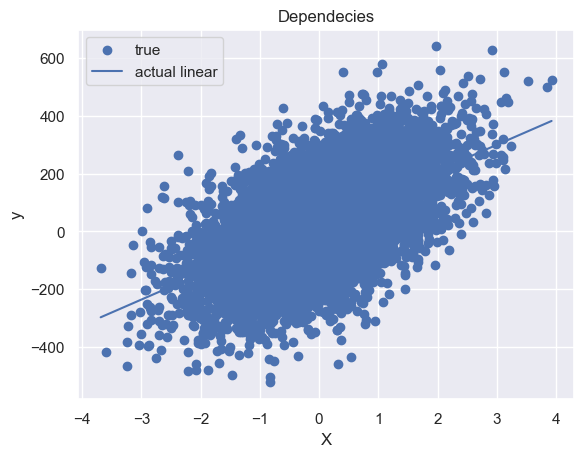

In [84]:
if n_features == 1 and n_targets == 1:
  draw_linear(X, Y, torch.Tensor([*coeff_actual, bias_actual]))

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
  X, Y, test_size=0.2, random_state=42
)

In [86]:
n_clients = 64

In [117]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
from common.distributor import UniformDataDistributor, HomogenousDataDistributorComplex
from optimization.federative.fedavg import FederatedAveraging, Model
from optimization.federative.scaffold import Scaffold

In [119]:
from function.vanilla import MSERidgeLinear, MSELassoLinear
from function.torch import TorchFunction

In [120]:
import torch

In [121]:
torch_model = torch.nn.Sequential(
  torch.nn.Linear(n_features, n_targets)
)
torch_function = TorchFunction(torch_model, torch.nn.MSELoss())

torch_enable = True

In [122]:
distributor = HomogenousDataDistributorComplex(
  X=X_train,
  y=y_train,
  n_parts=n_clients,
  iid_fraction=0.1
)
function = MSERidgeLinear(n_features=n_features)

if torch_model:
  function = torch_function
model = Model(function, distributor, save_history=True)

In [123]:
len(model.server.history), len(model.clients[0].history)

(0, 0)

In [124]:
model.clients.shape

(64,)

In [125]:
from common.pipeline import Pipeline


For parameters: {'clients_fraction': 0.1, 'batch_size': 16, 'epochs': 8, 'local_eta': 0.001, 'global_eta': 1}:
mse : inf
mae : 1.388056332663704e+23
mape : 4.3166338147401167e+21


/Users/locllos/anaconda3/envs/DS-3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)



For parameters: {'clients_fraction': 0.1, 'batch_size': 16, 'epochs': 128, 'local_eta': 0.001, 'global_eta': 1}:
mse : 2.5774041695506388e+26
mae : 13069060145152.0
mape : 437296168960.0

For parameters: {'clients_fraction': 0.1, 'batch_size': 64, 'epochs': 8, 'local_eta': 0.001, 'global_eta': 1}:
mse : 21042.951171875
mae : 115.1556396484375
mape : 1.225690484046936

For parameters: {'clients_fraction': 0.1, 'batch_size': 64, 'epochs': 128, 'local_eta': 0.001, 'global_eta': 1}:
mse : 16452.013671875
mae : 102.41632080078125
mape : 2.2256741523742676

For parameters: {'clients_fraction': 0.1, 'batch_size': 128, 'epochs': 8, 'local_eta': 0.001, 'global_eta': 1}:
mse : 19213.7265625
mae : 109.9970474243164
mape : 1.4197243452072144

For parameters: {'clients_fraction': 0.1, 'batch_size': 128, 'epochs': 128, 'local_eta': 0.001, 'global_eta': 1}:
mse : 16396.408203125
mae : 102.12577819824219
mape : 2.1502928733825684
done


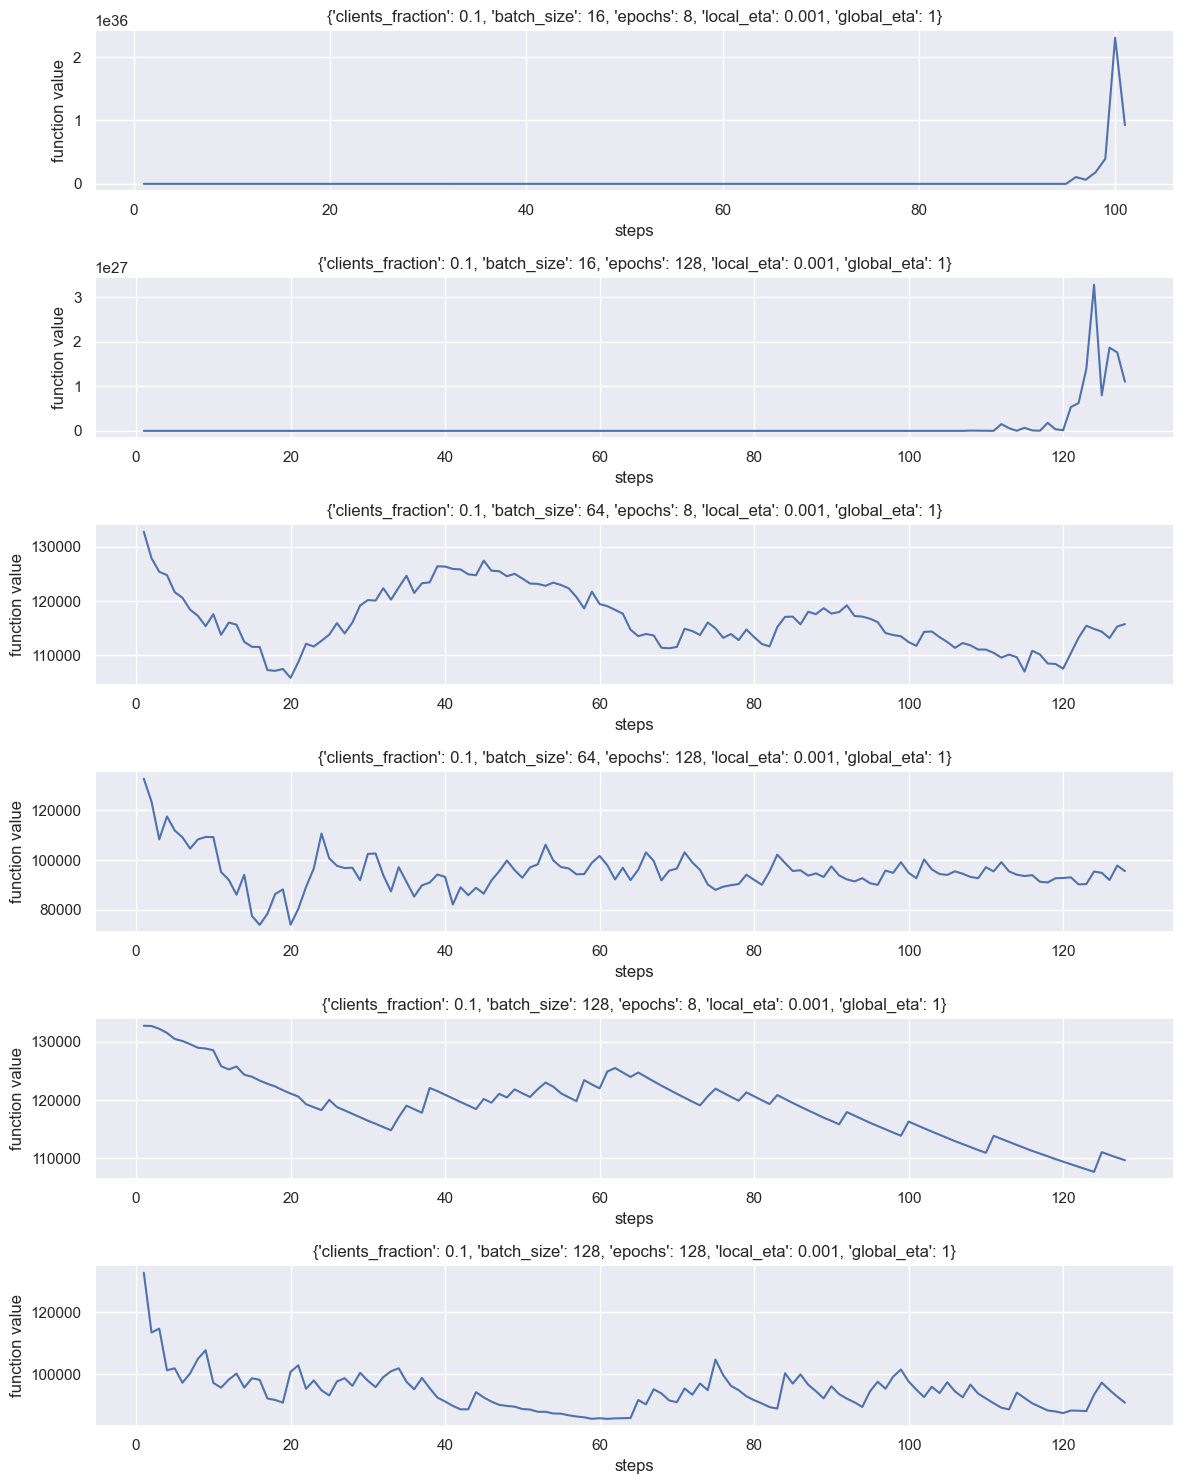

In [126]:
parameters = {
  "clients_fraction": [0.1],
  "batch_size": [16, 64, 128], 
  "epochs": [8, 128], # 16, 64,
  "rounds": [128],
  "local_eta": [1e-3], # , 1e-2
  "global_eta": [1],
}
metrics = {
  "mse" : mean_squared_error, 
  "mae" : mean_absolute_error, 
  "mape" : mean_absolute_percentage_error
}

pipeline = Pipeline(
  model=model,
  optimizer=Scaffold,
  parameters=parameters,
  metrics=metrics,
  X_val=X_test,
  y_val=y_test
)

best, best_params = pipeline.run(
  choose_best_by="mae",
  show_global_history=True
)
print("done")

In [243]:
[print(client.function.weights()) for client in best.clients]
best.server.function.weights()

[87.02875519 16.54732895 26.76180267]
[88.40120697 16.09644127 28.97192764]
[88.29789734 16.64553452 28.69553185]
[88.28618622 16.47437096 29.84837723]
[90.67804718 17.32872581 33.46662521]
[87.25054932 16.71495247 29.91583824]
[89.20217133 17.11396599 32.00629044]
[87.64431763 16.5369339  29.84012222]
[87.82408905 16.43651772 30.28582954]
[87.91385651 16.63656616 30.41523743]
[84.49358368 15.98053551 26.71639633]
[84.90032959 16.56193733 29.74707794]
[87.73214722 16.46376801 30.06217384]
[87.34291077 16.64769745 29.65203857]
[86.95018768 16.32097054 31.02388573]
[83.66849518 16.13712311 27.11419296]
[89.72611237 17.09044647 34.1906395 ]
[85.44940948 16.27840805 28.24328613]
[86.92347717 16.45904922 31.47735596]
[87.83951569 16.45985413 30.93379021]
[88.57498932 16.62008858 31.15825272]
[87.06758881 16.23383522 31.96328163]
[87.48330688 16.58581924 32.01660156]
[89.09142303 16.97338486 31.41016197]
[90.80971527 17.27460289 34.4323349 ]


array([88.06871033, 16.55269432, 29.81466103])

In [97]:
best_params

{'clients_fraction': 0.1, 'batch_size': 64, 'epochs': 64, 'eta': 0.0001}

In [98]:
if n_features == 1 and n_targets == 1:
  draw_linear(
    X_test, y_test, np.array([*coeff_actual, bias_actual]),
    best.server.function.predict(X_test), best.server.function.weights()
  )
print(f"\
  MSE: {mean_squared_error(y_test, best.server.function.predict(X_test))}\n\
  MAE: {mean_absolute_error(y_test, best.server.function.predict(X_test))}\n\
  MAPE: {mean_absolute_percentage_error(y_test, best.server.function.predict(X_test))}\
")

  MSE: 3201472975056.9033
  MAE: 1422888.412773519
  MAPE: 60059.89107808584


In [1]:
import torch

In [4]:
torch.vstack((torch.Tensor([1]), torch.Tensor([1])))

tensor([[1.],
        [1.]])

In [53]:
a = torch.arange(1, 4 * 5 + 1)
b = torch.arange(1, 4 * 1 + 1)
a, b

(tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20]),
 tensor([1, 2, 3, 4]))

In [56]:
torch.cat((a, b)).shape

torch.Size([24])

In [14]:
a[[[1, 2, 3], [2, 2, 2]]]

tensor([ 8, 13, 18])

In [22]:
def _by_norm2(data: np.ndarray):
  return np.linalg.norm(data, ord=2, axis=1)

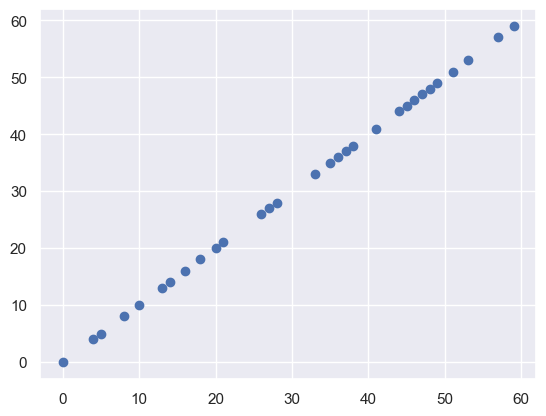

In [23]:
iid_fraction = 0.5
n_samples = 60

def _iid_size(total: int):
  return int(iid_fraction * total)

X = np.arange(0, n_samples).reshape((n_samples, 1))
y = np.arange(0, n_samples).reshape((n_samples, 1))

indices = np.arange(0, n_samples)
np.random.shuffle(indices)

iid = indices[:_iid_size(len(indices))]
X_iid = X[iid]
y_iid = y[iid]

plt.scatter(X_iid, y_iid)

In [24]:
non_iid = indices[_iid_size(len(indices)):]

y_non_iid = y[non_iid]
X_non_iid = X[non_iid]
sorted_non_iid = np.argsort(_by_norm2(y_non_iid))

y_non_iid = y_non_iid[sorted_non_iid]
X_non_iid = X_non_iid[sorted_non_iid]

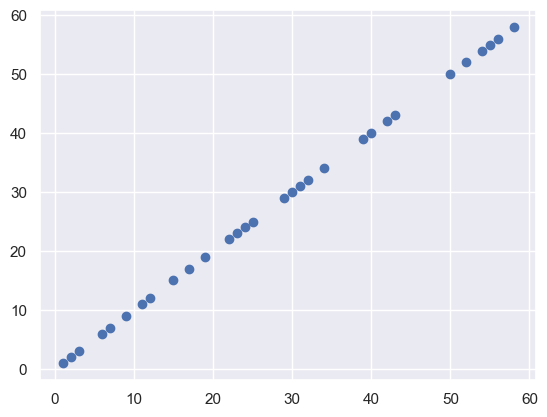

In [25]:
X_non_iid = X[non_iid]
y_non_iid = y[non_iid]
plt.scatter(X_non_iid, y_non_iid)

In [26]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from common.distributor import (
  UniformDataDistributor, HomogenousDataDistributor, HomogenousDataDistributorComplex
)
from optimization.federative.fedavg import FederatedAveraging
from optimization.federative.scaffold import Scaffold

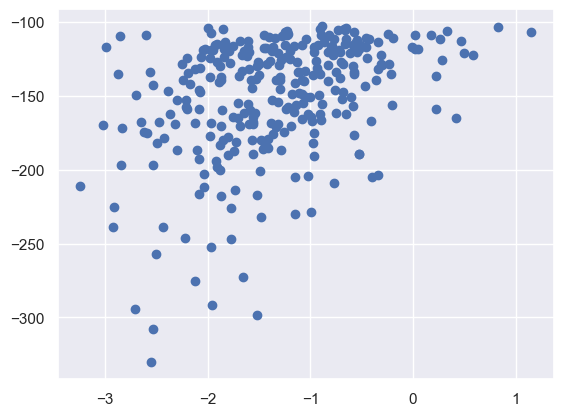

In [28]:
distrotest = HomogenousDataDistributorComplex(
  X=X_train,
  y=y_train,
  n_parts=10,
  iid_fraction=0
)
x, y = distrotest.server_portion()
plt.scatter(x, y)

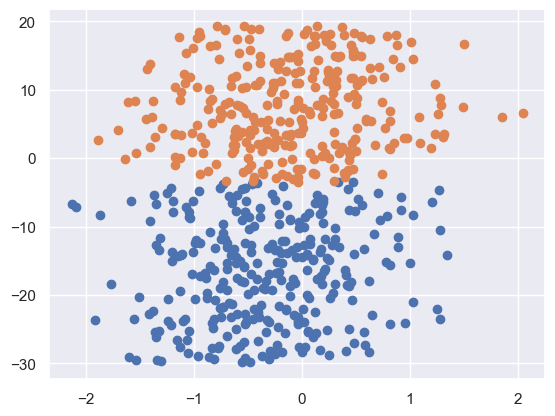

In [29]:
k = 0
for x, y in distrotest.clients_portions():
  if k == 2 or k == 3:
    plt.scatter(x, y)
  k += 1


In [30]:
import torch
from torch import nn

In [31]:
def check_weights(model: nn.Module):
  for i, parameters in enumerate(model.parameters()):
    print(f"\noriginal: {parameters=}\ntheory: {w[i]}\n---")

In [32]:
def step(model: nn.Module, theory_grads, w, old_w):
  with torch.no_grad():
    for i, parameters in enumerate(model.parameters()):
      w[i] -= 1e-3 * theory_grads[i](old_w[0], old_w[1], x, y)
      parameters -= 1e-3 * parameters.grad

In [33]:
theory_model_grad_loss_w1 = lambda w1, w2, x, y: -2 *(y - w1 * w2 * x) * w2 * x
theory_model_grad_loss_w2 = lambda w1, w2, x, y: -2 *(y - w1 * w2 * x) * w1 * x
theory_grads = [theory_model_grad_loss_w1, theory_model_grad_loss_w2]

In [34]:
model = nn.Sequential(
    nn.Linear(1, 1, bias=False), 
    nn.Linear(1, 1, bias=False), 
)
mse: nn.MSELoss = nn.MSELoss()
theory_model_loss = lambda w1, w2, x, y: (y - w1 * w2 * x) ** 2
mse

MSELoss()

In [35]:
w = [0. for _ in range(len(model))]
x = 1
y = 1

In [36]:
for i, parameters in enumerate(model.parameters()):
  w[i] = parameters.tolist()[0][0]
check_weights(model)


original: parameters=Parameter containing:
tensor([[-0.8766]], requires_grad=True)
theory: -0.8766436576843262
---

original: parameters=Parameter containing:
tensor([[0.2502]], requires_grad=True)
theory: 0.25017476081848145
---


In [37]:
predictions = model.forward(torch.Tensor([[x]]))
y_tensor =  torch.Tensor([[y]])

loss = mse(predictions, y_tensor)
loss, theory_model_loss(w[0], w[1], x, y)

(tensor(1.4867, grad_fn=<MseLossBackward0>), 1.4867269168524473)

In [38]:
loss.backward()

In [39]:
for theory_grad, parameters in zip(theory_grads, model.parameters()):
  print(f"{parameters=}")
  print(f"{parameters.grad=}")
  print(f"theory_grad: {theory_grad(w[0], w[1], x, y)}\n---")

parameters=Parameter containing:
tensor([[-0.8766]], requires_grad=True)
parameters.grad=tensor([[-0.6101]])
theory_grad: -0.6100832353583876
---
parameters=Parameter containing:
tensor([[0.2502]], requires_grad=True)
parameters.grad=tensor([[2.1378]])
theory_grad: 2.137807975459668
---


In [40]:
from copy import copy

old_w = copy(w)

In [41]:
step(model, theory_grads, w, old_w)

In [42]:
check_weights(model)


original: parameters=Parameter containing:
tensor([[-0.8760]], requires_grad=True)
theory: -0.8760335744489678
---

original: parameters=Parameter containing:
tensor([[0.2480]], requires_grad=True)
theory: 0.24803695284302177
---


In [43]:
model.zero_grad()

In [44]:
w[0] * x, w[1] * x

(-0.8760335744489678, 0.24803695284302177)

In [45]:
import torch

from torch import nn
from typing import List


class Flattener:
  def __init__(self, parameters_generator):
    self.shapes: List[torch.Size] = []

    parameters: nn.Parameter
    for parameters in parameters_generator:
      self.shapes.append(parameters.shape)

  def flatten(self, arrays: List[torch.Tensor]) -> np.ndarray:
    flat = np.array([])
    for array in arrays:
      flat = np.append(flat, array.numpy())

    return flat

  
  def unflatten(self, flat: np.ndarray) -> List[np.array]:
    arrays: List[torch.Tensor] = []
    
    start = 0
    for shape in self.shapes:
      arrays.append(torch.Tensor(flat[start : start + shape.numel()].reshape(shape)))
      
      start += shape.numel()

    return arrays

In [46]:
simple = nn.Sequential(
  nn.Linear(2, 1, bias=True),
  nn.Linear(1, 1, bias=True),
)
flattener = Flattener(simple.parameters())

loss = nn.MSELoss()
loss: torch.Tensor = simple.forward(torch.tensor([[1., 1.]]))
loss.backward()

updates: List[np.ndarray] = []
parameters_list: List[np.ndarray] = []

for parameters in simple.parameters():
  updates.append(parameters.grad.clone().detach())
  parameters_list.append(parameters.clone().detach())

In [47]:
flat_updates = flattener.flatten(updates)
flat_parameters_list = flattener.flatten(parameters_list)

In [48]:
flat_updates, flat_parameters_list

(array([-0.91267729, -0.91267729, -0.91267729, -0.07299209,  1.        ]),
 array([-0.59688079, -0.05466229,  0.57855099, -0.91267729, -0.88323534]))

In [49]:
all([(converted == actual).all() for converted, actual in zip(flattener.unflatten(flat_updates), updates)])

True

In [50]:
all([(converted == actual).all() for converted, actual in zip(flattener.unflatten(flat_parameters_list), parameters_list)])

True

In [51]:
parameters_list

[tensor([[-0.5969, -0.0547]]),
 tensor([0.5786]),
 tensor([[-0.9127]]),
 tensor([-0.8832])]

In [52]:
updates

[tensor([[-0.9127, -0.9127]]),
 tensor([-0.9127]),
 tensor([[-0.0730]]),
 tensor([1.])]

In [53]:
with torch.no_grad():
  for update, parameters in zip(flattener.unflatten(flat_updates), simple.parameters()):
    parameters += update

In [54]:
parameters_list = []
for parameters in simple.parameters():
  print(parameters)
  parameters_list.append(parameters.clone().detach().numpy())

Parameter containing:
tensor([[-1.5096, -0.9673]], requires_grad=True)
Parameter containing:
tensor([-0.3341], requires_grad=True)
Parameter containing:
tensor([[-0.9857]], requires_grad=True)
Parameter containing:
tensor([0.1168], requires_grad=True)


In [55]:
updates

[tensor([[-0.9127, -0.9127]]),
 tensor([-0.9127]),
 tensor([[-0.0730]]),
 tensor([1.])]

In [56]:
updates

[tensor([[-0.9127, -0.9127]]),
 tensor([-0.9127]),
 tensor([[-0.0730]]),
 tensor([1.])]

In [57]:
parameters_list

[array([[-1.5095581, -0.9673396]], dtype=float32),
 array([-0.3341263], dtype=float32),
 array([[-0.9856694]], dtype=float32),
 array([0.11676466], dtype=float32)]

In [58]:
array = np.arange(0, 3 * 4).reshape((3, 4))
array

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [59]:
array.flatten().reshape(array.shape)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])